# Create Scenarios in CommonRoad

## Using commonroad.scenario

In [1]:
import os
from IPython import display

import numpy as np
from numba import njit
import matplotlib.pyplot as plt


In [10]:
from commonroad.scenario.lanelet import Lanelet,LaneletNetwork,LaneletType
from commonroad.scenario.intersection import Intersection

from commonroad.scenario.obstacle import DynamicObstacle,StaticObstacle,ObstacleType
from commonroad.geometry.shape import Rectangle
from commonroad.scenario.scenario import Scenario,ScenarioID

from commonroad.planning.planning_problem import PlanningProblem,PlanningProblemSet

from commonroad.planning.goal import GoalRegion

from commonroad.scenario.trajectory import State,Trajectory
from commonroad.common.util import Interval
from commonroad.prediction.prediction import TrajectoryPrediction

from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.draw_dispatch_cr import draw_object
from commonroad.visualization.mp_renderer import MPRenderer

In [3]:
sample_file = './data/ZAM_Tutorial-1_1_T-1.xml'

scenario, planning_ps = CommonRoadFileReader(sample_file).open()
rn = MPRenderer
print(scenario)


Scenario:
- Scenario ID: ZAM_Tutorial-1_1_T-1
- Time step size: 0.1
- Number of Obstacles: 1
- Lanelets:
       1 lanelet
       2 lanelet
       3 lanelet



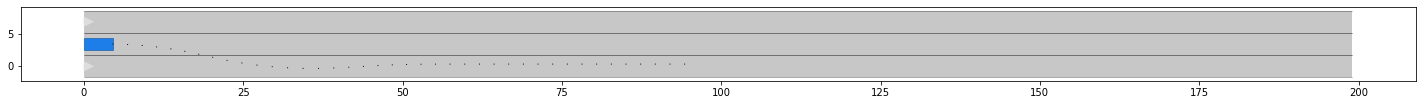

In [19]:
# for i in [10,20]:
for i in range(0, 1):
    plt.figure(figsize=(25, 10))
    rnd = MPRenderer()
#     scenario.draw(rnd, draw_params={'time_begin': i})
    scenario.lanelet_network.draw(rnd, draw_params={'time_begin': i})
#     planning_ps.draw(rnd)
    scenario.dynamic_obstacles[0].draw(rnd,draw_params= {'time_begin': i})
    rnd.render()

In [8]:
planning_ps.planning_problem_dict[100]

In [26]:
sam_scenario = Scenario(dt=0.1,scenario_id=0)

In [8]:
static_obstance_id = sam_scenario.generate_object_id()
static_obstance_type = ObstacleType.PARKED_VEHICLE

static_obstance_shape = Rectangle(width=2.0,length=4.5)
static_obstance_initial_state = State(position=np.array([30.,3.5]),
                                     orientation=0.02,
                                     time_step=0)
static_obstacle = StaticObstacle(static_obstance_id,static_obstance_type,static_obstance_shape,static_obstance_initial_state)
print(static_obstacle)

Static Obstacle:

id: 1
type: parkedVehicle
initial state: 
position= [30.   3.5]
orientation= 0.02
time_step= 0



In [9]:
d_obstacle_id = sam_scenario.generate_object_id()
d_obstacle_type = ObstacleType.CAR
d_obstacle_shape = Rectangle(width=2.0,length=4.5)
d_obstacle_initial_state_1 = State(position=np.array([30.,3.5]),
                                velocity=22,
                                orientation=.02,
                                time_step=0)
d_obstacle_initial_state_2 = State(position=np.array([25.,3.5]),
                                velocity=20,
                                orientation=.02,
                                time_step=0)
d_obstacle_initial_state_3 = State(position=np.array([20.,3.5]),
                                velocity=18,
                                orientation=.02,
                                time_step=0)

d_obstacle_1 = DynamicObstacle(d_obstacle_id,d_obstacle_type,d_obstacle_shape,d_obstacle_initial_state_1)
d_obstacle_2 = DynamicObstacle(d_obstacle_id,d_obstacle_type,d_obstacle_shape,d_obstacle_initial_state_2)
d_obstacle_3 = DynamicObstacle(d_obstacle_id,d_obstacle_type,d_obstacle_shape,d_obstacle_initial_state_3)

### Bringing Argoverse Paths

In [24]:
from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.utils.centerline_utils import centerline_to_polygon
from shapely.geometry.polygon import Polygon
from shapely.ops import cascaded_union

try:
    if map_obj:
        print("Hi")
except NameError:
    map_obj = ArgoverseMap()

9614065


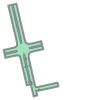

In [27]:
lane_cl_dict = map_obj.city_lane_centerlines_dict['PIT']
lane = np.random.choice(list(lane_cl_dict))
lane = 9614065
print(lane)
cl = lane_cl_dict[lane].centerline
polygon = centerline_to_polygon(cl)
Polygon(polygon)

# find near by lanes
point = cl[0]
lanes = map_obj.get_lane_ids_in_xy_bbox(*point,'PIT',25)

polys = []
for ll in lanes:
    cl = lane_cl_dict[ll].centerline
    polygon = centerline_to_polygon(cl)
    polygon = Polygon(polygon)
    polys.append(polygon)
    
all_added = cascaded_union(polys)
all_added

## Convert to an automated way to find 

1. Left vertices
2. centerline
3. right vertcies
4. id
5. predecessor,successor,~adj_left,adj_right~

In [28]:
@njit
def cl_to_lines(cl,polygon):
    lx = polygon[0][:11].reshape(-1,1)
    ly = polygon[1][:11].reshape(-1,1)
    left = np.hstack((lx,ly))
    rx = polygon[0][10:].reshape(-1,1)
    ry = polygon[1][10:].reshape(-1,1)
    right = np.hstack((rx,ry))
    return left,cl,right

def lane_to_lanelet(laneid,viz:bool=False):
    # lane_cl_dict
    cl = lane_cl_dict[laneid].centerline 
    preds = lane_cl_dict[laneid].predecessors
    succs = lane_cl_dict[laneid].successors
    adj_l = lane_cl_dict[laneid].l_neighbor_id
    adj_r = lane_cl_dict[laneid].r_neighbor_id
    polygon = Polygon(centerline_to_polygon(cl)).exterior.xy
    polygon = np.array(polygon)
    polygon[0] = np.array(polygon[0])
    polygon[1] = np.array(polygon[1])
    ll,cc,rr = cl_to_lines(np.float64(cl),np.float64(polygon))
    lanelet = Lanelet(ll,cc,rr,laneid,preds,succs)
    if viz:
        for i in [ll,cc,rr]:
            plt.plot(i[:,0],i[:,1])
        plt.show()
    return lanelet

def form_lane_network(point,city='PIT',dis_threshold:float=20):
    lanes = map_obj.get_lane_ids_in_xy_bbox(*point,city,dis_threshold)
    lanelets = []
    for lane in lanes:
        lanelet = lane_to_lanelet(lane,False)
        lanelets.append(lanelet)
        
    network = LaneletNetwork.create_from_lanelet_list(lanelets)
    return network

In [29]:
# lane = np.random.choice(list(lane_cl_dict))
res = lane_to_lanelet(lane,False)
net = form_lane_network(point)

### Add map to scenario

1. Add Dynamic obstacles

In [30]:
sam_scenario = Scenario(dt=0.1,scenario_id=1,location="PITSBURG")
sam_scenario.lanelet_network = net
sam_scenario.translate_rotate(-point,np.radians(78))

In [31]:
d_obstacle_id = sam_scenario.generate_object_id()
d_obstacle_type = ObstacleType.CAR
d_obstacle_shape = Rectangle(width=2.0,length=4.5)
d_obstacle_initial_state_1 = State(position=[0,0],
                                velocity=22,
                                orientation=.02,
                                time_step=0)

d_obstacle_1 = DynamicObstacle(d_obstacle_id,d_obstacle_type,d_obstacle_shape,
                               d_obstacle_initial_state_1,initial_center_lanelet_ids={9613722})
sam_scenario.add_objects(d_obstacle_1)
print(point)
print([i.lanelet_id for i in sam_scenario.lanelet_network.lanelets])

[4658.73731871 2543.26904625]
[9613488, 9613640, 9613717, 9613722, 9613784, 9613835, 9613885, 9614063, 9614065, 9614111, 9614124, 9614132, 9614156, 9614159, 9614177, 9614190, 9614194, 9614206, 9614216, 9614232, 9617739, 9617745]


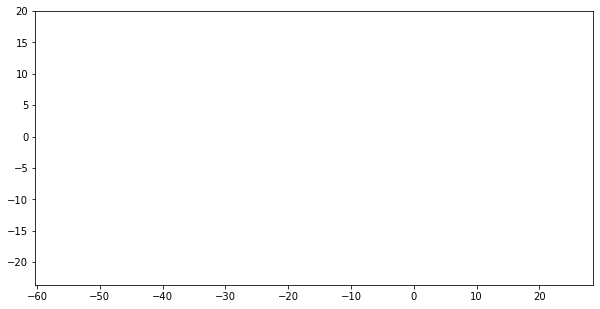

In [32]:
fig = plt.figure(figsize=(10,10))
rnd = MPRenderer()
draw_object(sam_scenario,draw_params={'time_begin' : 0})
_ = rnd.render()
plt.show()

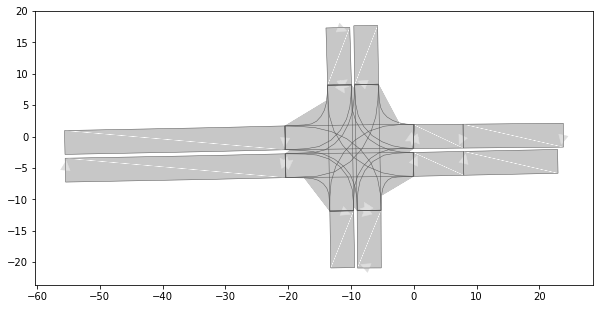

In [33]:
fig = plt.figure(figsize=(10,10))
rnd = MPRenderer()
sam_scenario.draw(rnd,draw_params={'time_begin':0})
_ = rnd.render()
plt.show()

In [60]:
inital_shape = Rectangle(length=4.5,width=2.0,center=np.array([-40,-6]))
initial_state = State(position=inital_shape,velocity=Interval(4,4.5),orientation=0.0,slip_angle=0.0,time_step=0.1,yaw_rate=0)

final_shape = Rectangle(length=4.5,width=2.0,center=np.array([0,-6]))
final_state = State(position=final_shape,velocity=Interval(4,4.5),time_step=Interval(0.1,0.12))

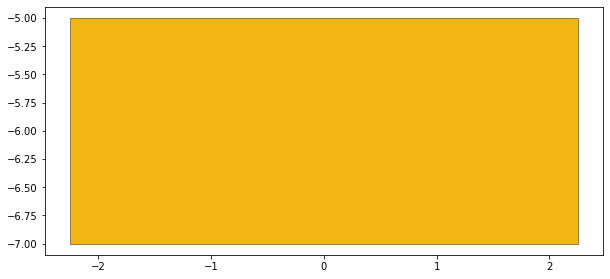

In [57]:
def show(x,**kwargs):
    fig = plt.figure(figsize=(10,10))
    rnd = MPRenderer()
    if kwargs is None:
        x.draw(rnd)
    else:
        x.draw(rnd,draw_params=kwargs)
    _ = rnd.render()
    plt.show()
    
show(GoalRegion([final_state]))

In [62]:
prblm = PlanningProblem(1,initial_state,GoalRegion([final_state]))

TypeError: 'Rectangle' object is not subscriptable

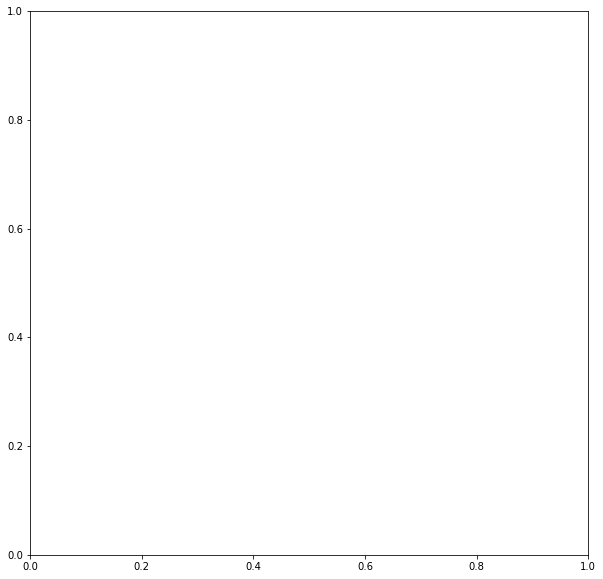

In [63]:
show(prblm)